In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import pandas as pd
from math import *
from datetime import datetime
import pygeodesy
from scipy import stats
import seaborn as sns

plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams.update({'font.size': 16})

In [98]:
# Note that this is an already-processed and interpolated file
# this notebook can theoretically be run on any file, but contains analysis specific to FLY342
# 340, 341, 342, 343, 344, 347, 349, 352, 352, 353
NAME = 'FLY340'

# Read the processed file into pandas
df = pd.read_csv("/hirax/rf_data/bnl_202003/drone_data/drone_20200312_reprocessed/re_reprocessed/"+NAME+"_processed.csv", sep=',', header=0)
df_old = pd.read_csv("/hirax/rf_data/bnl_202003/drone_data/drone_20200312/"+NAME+"_processed.csv", sep=',', header=0)
#df = pd.read_csv("~/Downloads/FLY342_reduced.csv", sep=",", header=0)

# When the file is first read, all the timestamps will be strings
# So convert them to datetime objects
df = df.assign(timestamp = pd.to_datetime(df.timestamp))
df = df.assign(datetimestamp = pd.to_datetime(df.datetimestamp))
df_old = df_old.assign(timestamp = pd.to_datetime(df_old.timestamp))
df_old = df_old.assign(datetimestamp = pd.to_datetime(df_old.datetimestamp))
print(len(df))

170487


## Previous timestamp generator
Assumes that there is no clock drift in `sec_elasped` and that `datetimestamp` is a correct measure of UTC time

Also has a lot of mistakes that introduce +/- 200ms of error into the clock. Do not use.

In [99]:
# The following code is what generates the timestamp column:
# get a clock tick near sec_elapsed = 0

in_flight  = df[df.sec_elapsed > 0.]
first_time = in_flight["datetimestamp"].values[0]

# find the first in-flight clock tick
tick_row = 0
while in_flight["datetimestamp"].values[tick_row] == first_time:
    tick_row += 1
    if tick_row >= len(in_flight.datetimestamp): 
        tick_row -= 1
        break

tick_num = in_flight["tick"].values[tick_row]

# we are declaring this row to be t=0
# shift sec_elapsed to fit this
sec_offset = -1.*in_flight['sec_elapsed'].values[tick_row]

# adjust the offset for time=0 at motor start, not flight start
tick_row = tick_row + (len(df.tick) - len(in_flight.tick))
init_time = np.datetime64(df["datetimestamp"].values[tick_row])

# apply the offset to the sec_elapsed column
secs = np.add(df.sec_elapsed, sec_offset)

# THIS IS THE PART WHERE EVERYTHING GOES WRONG
# THIS CODE IS BAD FOR MANY REASONS AND INTRODUCES A LOT OF ERROR :(
deltas = []
i=0
for row in secs:
    sec = floor(row)
    milli = int((row - sec)*1000)
    if(milli > 1000): print(milli)
    sec_delta = np.timedelta64(sec, 's')
    mil_delta = np.timedelta64(milli, 'ms')
    delta = sec_delta + mil_delta
    deltas.append(delta)
    i+=1

# make the new timestamps
moved_times = []
for i in range(len(deltas)):
    moved_times.append(df["datetimestamp"].values[i] + np.timedelta64(int(1000*(secs[i]-floor(secs[i]))), 'ms'))
    
df['generated_timestamp'] = moved_times

## New timestamp generator
Assumes that `datetimestamp` ticks exactly once per second (which is false), and that it does not drift relative to `sec_elasped`. Better than the previous version, but does not solve all our problems.

In particular, **the rate of the passage of time is not maintained at 1 second per second!**

In [100]:
# rewritten timestamp interpolation
# removes dependance on sec_elapsed
# note that this assumes rows are evenly spaced, which is probably not true!!
last_time = df["datetimestamp"].values[0]
this_time = df["datetimestamp"].values[1]
tick_indices = [0] # indices into the df where the datetimestamp ticks over
tick_sec_elapsed = [] # the value of sec_elapsed when the clock ticks over

# find all the rows where the datetimestamp ticks over
for i in range(1, len(df)):
    this_time = df["datetimestamp"].values[i]
    if last_time != this_time: 
        tick_indices.append(i)
        tick_sec_elapsed.append(df["sec_elapsed"].values[i])
        if(this_time-last_time > np.timedelta64(1, 's')):
            print("That's a really long second!!") # this does not happen.
            print("datetimestamp ticks by "+str((this_time-last_time)/np.timedelta64(1,'s'))+" seconds at row "+str(i)+" of "+str(len(df)))
    last_time = this_time

tick_indices.append(len(df))
    
corrected_timestamps = []

# add in the sub-second values for every second

second_length = tick_indices[0]

for i in range (0, len(tick_indices)-1): # for each second
    second_length = tick_indices[i+1]-tick_indices[i]
    for j in range(tick_indices[i+1]-tick_indices[i]): # for each row in a given second
        uncorrected = df["datetimestamp"].values[tick_indices[i]+j] # datetimestamp to correct
        correction = j*(1./second_length) # correction, in seconds
        correction = np.timedelta64(int(correction*1000),'ms') # convert correction to milliseconds
        corrected_timestamps.append(uncorrected + correction) # correct the timestamp

df['interpolated_timestamp'] = corrected_timestamps

## Newer timestamp generator
Improved version of the Old Timestamp Generator

Assumes that `sec_elapsed` does not drift, and that `datetimestamp` is a correct measure of UTC time
This method is correct to within a +/- 200ms overall offset. I believe it is currently the best we can do.

In [101]:
# get a clock tick near sec_elapsed = 0

in_flight  = df[df.sec_elapsed > 0.]
first_time = in_flight["datetimestamp"].values[0]

tick_row = 0
# find the first in-flight clock tick
while in_flight["datetimestamp"].values[tick_row] == first_time:
    tick_row += 1
    if tick_row >= len(in_flight.datetimestamp): 
        tick_row -= 1
        break

tick_num = in_flight["tick"].values[tick_row]

# we are declaring this row to be t=0
# shift sec_elapsed to fit this
sec_offset = -1.*in_flight['sec_elapsed'].values[tick_row]

# adjust the offset for time=0 at motor start, not flight start
tick_row = tick_row + (len(df.tick) - len(in_flight.tick))

# find the datetimestamp at our t=0
init_time = np.datetime64(df["datetimestamp"].values[tick_row])

# offset the sec_elapsed column so that it is 0 at our new t=0
secs = np.add(df.sec_elapsed, sec_offset)

# use the offset secs to make a new set of UTC timestamps
deltas = []
secs=np.array(secs.values)

for i in secs:
    deltas.append(np.timedelta64(int(i*1000), 'ms'))
new_timestamps = init_time + deltas

df['new_timestamp'] = new_timestamps

In [102]:
df_ds = df.drop_duplicates(subset=["Lat", "Lon", "hmsl", "datetimestamp"]) #df_DownSampled
print(df.columns)
print(len(df))
print(len(df_ds))
print(len(df)/len(df_ds))

first_time = df_ds["datetimestamp"].values[0]
last_time = df_ds["datetimestamp"].values[0]
this_time = df_ds["datetimestamp"].values[1]
ds_tick_indices = [0] # indices into the df where the datetimestamp ticks over
ds_tick_sec_elapsed = [] # the value of sec_elapsed when the clock ticks over
ds_dt_series = []

# find all the rows where the datetimestamp ticks over
for i in range(1, len(df_ds)):
    this_time = df_ds["datetimestamp"].values[i]
    ds_dt_series.append((this_time-first_time)/np.timedelta64(1,'s'))
    if last_time != this_time: 
        ds_tick_indices.append(i)
        ds_tick_sec_elapsed.append(df_ds["sec_elapsed"].values[i])
        if(this_time-last_time > np.timedelta64(1, 's')):
            print("That's a really long second!!") # this does not usually happen.
            print("datetimestamp ticks by "+str((this_time-last_time)/np.timedelta64(1,'s'))+" seconds at row "+str(i)+" of "+str(len(df)))
    last_time = this_time

slope, intercept, r_value, p_value, stderr = stats.linregress(range(len(ds_dt_series)), ds_dt_series)
print(slope)
print(intercept)
fit_dt_series = range(len(ds_dt_series))*slope + intercept

for i in range(len(ds_dt_series)):
    print(ds_dt_series[i], fit_dt_series[i])


Index(['Unnamed: 0', 'Lat', 'Lon', 'hmsl', 'sec_elapsed', 'datetimestamp',
       'tick', 'vel', 'yaw_rtk', 'pitch_rtk', 'pitch', 'roll', 'yaw',
       'yaw_360', 'IMU_lat', 'IMU_lon', 'IMU_hmsl', 'interpolated_timestamp',
       'timestamp', 'generated_timestamp', 'new_timestamp'],
      dtype='object')
170487
9941
17.14988431747309
0.1779218947322218
0.1161380920063948
0.0 0.1161380920063948
0.0 0.2940599867386166
0.0 0.4719818814708384
1.0 0.6499037762030602
1.0 0.827825670935282
1.0 1.005747565667504
1.0 1.1836694603997255
1.0 1.3615913551319474
1.0 1.5395132498641693
1.0 1.7174351445963911
2.0 1.895357039328613
2.0 2.0732789340608346
2.0 2.2512008287930563
2.0 2.4291227235252784
3.0 2.6070446182575
3.0 2.784966512989722
3.0 2.9628884077219437
3.0 3.1408103024541654
3.0 3.3187321971863875
3.0 3.496654091918609
3.0 3.674575986650831
4.0 3.852497881383053
4.0 4.0304197761152745
4.0 4.2083416708474966
4.0 4.386263565579718
5.0 4.56418546031194
5.0 4.742107355044162
5.0 4.9200292497763

237.0 240.66653976997029
237.0 240.8444616647025
238.0 241.02238355943473
238.0 241.20030545416694
238.0 241.37822734889917
238.0 241.55614924363138
238.0 241.73407113836362
238.0 241.91199303309583
239.0 242.08991492782806
239.0 242.26783682256027
239.0 242.4457587172925
239.0 242.6236806120247
240.0 242.80160250675695
240.0 242.97952440148916
240.0 243.1574462962214
240.0 243.3353681909536
240.0 243.51329008568584
241.0 243.69121198041805
241.0 243.86913387515028
241.0 244.0470557698825
241.0 244.22497766461473
241.0 244.40289955934693
242.0 244.58082145407917
242.0 244.75874334881138
242.0 244.93666524354362
242.0 245.11458713827582
242.0 245.29250903300806
242.0 245.47043092774027
242.0 245.6483528224725
243.0 245.8262747172047
243.0 246.00419661193695
243.0 246.18211850666916
243.0 246.36004040140136
243.0 246.5379622961336
243.0 246.7158841908658
243.0 246.89380608559804
244.0 247.07172798033025
244.0 247.2496498750625
244.0 247.4275717697947
244.0 247.60549366452693
245.0 247.78

571.0 571.4233420771707
571.0 571.6012639719029
572.0 571.7791858666351
572.0 571.9571077613673
572.0 572.1350296560995
572.0 572.3129515508317
572.0 572.4908734455639
573.0 572.6687953402961
573.0 572.8467172350284
573.0 573.0246391297607
573.0 573.2025610244929
574.0 573.3804829192251
574.0 573.5584048139573
574.0 573.7363267086895
574.0 573.9142486034217
574.0 574.0921704981539
574.0 574.2700923928861
575.0 574.4480142876184
575.0 574.6259361823506
575.0 574.8038580770829
575.0 574.9817799718151
575.0 575.1597018665473
575.0 575.3376237612795
575.0 575.5155456560117
576.0 575.6934675507439
576.0 575.8713894454762
576.0 576.0493113402084
576.0 576.2272332349406
576.0 576.4051551296728
577.0 576.583077024405
577.0 576.7609989191373
577.0 576.9389208138695
577.0 577.1168427086017
577.0 577.294764603334
577.0 577.4726864980662
577.0 577.6506083927984
578.0 577.8285302875306
578.0 578.0064521822628
578.0 578.184374076995
578.0 578.3622959717272
578.0 578.5402178664594
578.0 578.718139761

908.0 905.382738489551
908.0 905.5606603842832
908.0 905.7385822790154
908.0 905.9165041737476
908.0 906.0944260684798
909.0 906.272347963212
909.0 906.4502698579442
909.0 906.6281917526765
909.0 906.8061136474088
909.0 906.984035542141
909.0 907.1619574368732
910.0 907.3398793316054
910.0 907.5178012263376
910.0 907.6957231210698
910.0 907.873645015802
910.0 908.0515669105342
911.0 908.2294888052666
911.0 908.4074106999988
911.0 908.585332594731
911.0 908.7632544894632
911.0 908.9411763841954
911.0 909.1190982789276
911.0 909.2970201736598
912.0 909.474942068392
912.0 909.6528639631243
912.0 909.8307858578565
912.0 910.0087077525887
912.0 910.186629647321
913.0 910.3645515420532
913.0 910.5424734367854
913.0 910.7203953315176
913.0 910.8983172262498
913.0 911.0762391209821
913.0 911.2541610157143
913.0 911.4320829104465
914.0 911.6100048051787
914.0 911.7879266999109
914.0 911.9658485946431
914.0 912.1437704893754
915.0 912.3216923841076
915.0 912.4996142788398
915.0 912.6775361735721

1246.0 1246.45901069122
1247.0 1246.6369325859523
1247.0 1246.8148544806845
1247.0 1246.9927763754167
1247.0 1247.1706982701492
1248.0 1247.3486201648814
1248.0 1247.5265420596136
1248.0 1247.7044639543458
1248.0 1247.882385849078
1248.0 1248.0603077438102
1248.0 1248.2382296385424
1249.0 1248.4161515332746
1249.0 1248.5940734280068
1249.0 1248.771995322739
1249.0 1248.9499172174712
1249.0 1249.1278391122034
1249.0 1249.3057610069357
1249.0 1249.4836829016679
1250.0 1249.6616047964
1250.0 1249.8395266911323
1250.0 1250.0174485858645
1250.0 1250.195370480597
1250.0 1250.3732923753291
1251.0 1250.5512142700613
1251.0 1250.7291361647935
1251.0 1250.9070580595258
1251.0 1251.084979954258
1251.0 1251.2629018489902
1252.0 1251.4408237437224
1252.0 1251.6187456384546
1252.0 1251.7966675331868
1252.0 1251.974589427919
1252.0 1252.1525113226512
1252.0 1252.3304332173834
1253.0 1252.5083551121156
1253.0 1252.6862770068478
1253.0 1252.86419890158
1253.0 1253.0421207963125
1253.0 1253.220042691044

1579.0 1578.8171100510106
1579.0 1578.9950319457428
1579.0 1579.172953840475
1579.0 1579.3508757352072
1580.0 1579.5287976299394
1580.0 1579.7067195246716
1580.0 1579.8846414194038
1580.0 1580.062563314136
1580.0 1580.2404852088682
1581.0 1580.4184071036004
1581.0 1580.5963289983326
1581.0 1580.7742508930648
1581.0 1580.952172787797
1581.0 1581.1300946825295
1581.0 1581.3080165772617
1582.0 1581.485938471994
1582.0 1581.663860366726
1582.0 1581.8417822614583
1582.0 1582.0197041561905
1582.0 1582.1976260509227
1582.0 1582.375547945655
1582.0 1582.5534698403872
1583.0 1582.7313917351194
1583.0 1582.9093136298516
1583.0 1583.0872355245838
1583.0 1583.265157419316
1583.0 1583.4430793140482
1583.0 1583.6210012087804
1584.0 1583.7989231035126
1584.0 1583.976844998245
1584.0 1584.1547668929772
1584.0 1584.3326887877095
1584.0 1584.5106106824417
1585.0 1584.6885325771739
1585.0 1584.866454471906
1585.0 1585.0443763666383
1585.0 1585.2222982613705
1586.0 1585.4002201561027
1586.0 1585.578142050

## Linear fit timestamp interpolation
Same assumptions as the previous, but chooses an offset that best fits the whole data set, rather than arbitrarily choosing the first item.

In [103]:
first_time = df["datetimestamp"].values[0]
dt_series = []

# make a list of timedeltas from the first datetimestamp
for i in range(len(df)):
    dt_series.append((df["datetimestamp"].values[i]-first_time)/np.timedelta64(1,'s'))

dt_series = np.array(dt_series)
x_series = np.array(range(len(dt_series)))
diff_series = np.diff(dt_series)
    
    
# try to find outliers
top_n = 10
top = (-diff_series).argsort()[:top_n]
print(diff_series[top])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [109]:
first_time = df["datetimestamp"].values[0]
dt_series = []
trim = 1

# make a list of timedeltas from the first datetimestamp
for i in range(len(df)):
    dt_series.append((df["datetimestamp"].values[i]-first_time)/np.timedelta64(1,'s'))

# fit a line to the timedeltas as a function of sec_elapsed
slope, intercept, r_value, p_value, stderr = stats.linregress(df['sec_elapsed'].values[trim:-trim], dt_series[trim:-trim])
# I SHOULD NOT DO THIS, IT'S PROBABLY REALLY BAD STATISTICS
# add 0.5s to the intercept, because this is a fit to the floor of a function
intercept += 0.5

# use the coefficients of the linear fit to generate timestamps
fit_dt_series = df.sec_elapsed*slope + intercept
fit_datetimes = []
for i in range(len(df)):
    fit_datetimes.append(first_time + np.timedelta64(int(fit_dt_series[i]*1000), 'ms'))

#for i in range(100):
#    print(df['datetimestamp'].values[i], fit_datetimes[i])
        
print(max(np.diff(df['sec_elapsed'].values)))
print(np.argmax(np.diff(df["sec_elapsed"].values)))
print(len(df))
df["linfit_timestamp"] = fit_datetimes

0.44099999999980355
72562
170487


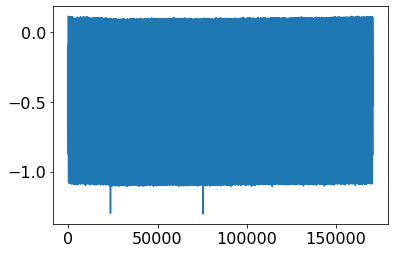

In [111]:
# check the fit

# dt_series is the experimental data
# we need a similar series for the fit
first_fit_time = df["datetimestamp"].values[0]
fit_dt_series = []
for i in range(len(df)):
    fit_dt_series.append((df["linfit_timestamp"].values[i]-first_time)/np.timedelta64(1,'s'))
    
# now we can find and plot residuals
residuals = np.array(dt_series)-np.array(fit_dt_series)

plt.plot(residuals[trim:-trim])

## Old vs. New comparison

[151817, 151912, 151987, 152082, 152181]
152181


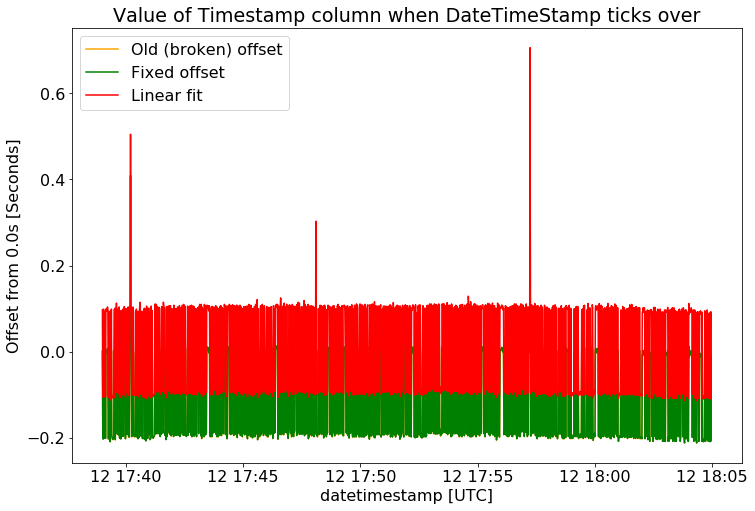

In [87]:
indices = tick_indices[10:-10]
print(tick_indices[-5:])
print(len(df))

old_deltas = df_old["timestamp"].values[indices]-df_old["datetimestamp"].values[indices]
old_deltas = old_deltas/np.timedelta64(1, 's')

new_deltas = df["timestamp"].values[indices]-df["datetimestamp"].values[indices]
new_deltas = new_deltas/np.timedelta64(1, 's')

linfit_deltas = df["linfit_timestamp"].values[indices]-df["datetimestamp"].values[indices]
linfit_deltas = linfit_deltas/np.timedelta64(1, 's')

newer_deltas = df["new_timestamp"].values[indices]-df["datetimestamp"].values[indices]
newer_deltas = newer_deltas/np.timedelta64(1, 's')

plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(12,8))
plt.title("Value of Timestamp column when DateTimeStamp ticks over")
plt.xlabel("datetimestamp [UTC]")
plt.ylabel("Offset from 0.0s [Seconds]")
plt.plot(df_old["datetimestamp"].values[indices], old_deltas, c='orange', label="Old (broken) offset")
plt.plot(df["datetimestamp"].values[indices], newer_deltas, c='g', label="Fixed offset")
plt.plot(df["datetimestamp"].values[indices], linfit_deltas, c='r', label="Linear fit")
plt.legend()
plt.show()

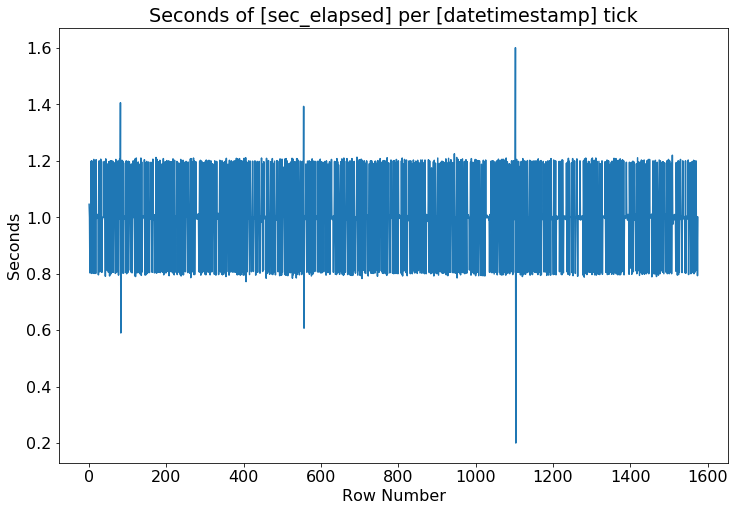

In [88]:
# Why we can't use the interpolation

second_length = []

for i in range (0, len(tick_indices)-2): # for each second
    second_length.append(df['sec_elapsed'].values[tick_indices[i+1]]-df['sec_elapsed'].values[tick_indices[i]])

fig = plt.figure(figsize=(12, 8))
plt.title("Seconds of [sec_elapsed] per [datetimestamp] tick")
plt.xlabel("Row Number")
plt.ylabel("Seconds")
plt.plot(second_length)


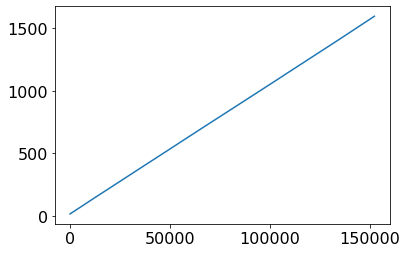

In [89]:
plt.plot(df.sec_elapsed)

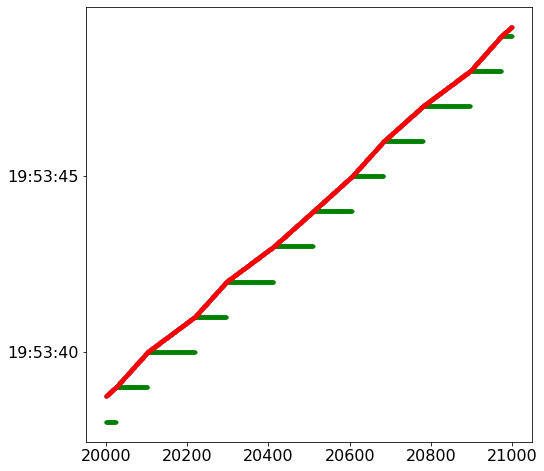

In [15]:
# sanity check for discontinuities
start = 20000
end = 21000
plt.plot(df.datetimestamp[start:end],'.',c='g')
plt.plot(df.timestamp[start:end],'.')
plt.plot(df.interpolated_timestamp[start:end],'.', c='r')

plt.show()


## Investigating the errors

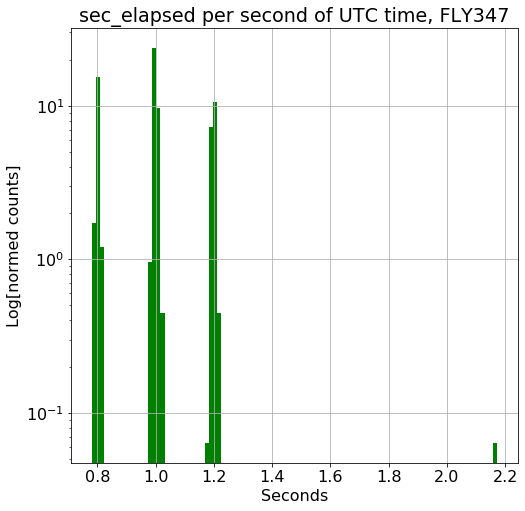

2.173000000000002
106543
2020-03-12T20:08:33.000000000
2020-03-12T20:08:34.000000000
2020-03-12T20:08:34.000000000
Number of entries in the previous tick: 114
Number of entries in this tick: 96


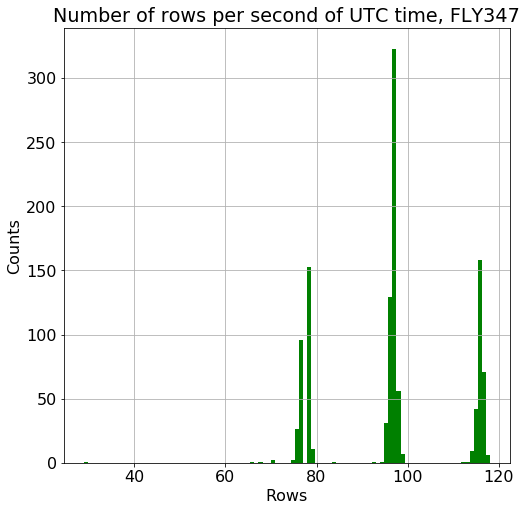

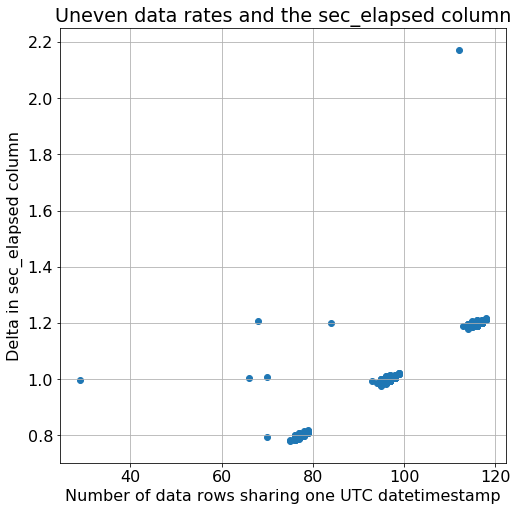

In [17]:
elapsed_secs = []
entries_per_tick = []
max_elapsed_secs = 0;
max_elapsed_idx = 0;
max_elapsed_ticknum = 0;

# cut the first 10 rows, which contain major outliers
for i in range(10, len(indices)-1):
    t = df["sec_elapsed"].values[indices[i+1]] - df["sec_elapsed"].values[indices[i]]
    entries = indices[i+1] - indices[i]
    if (t > max_elapsed_secs and i > 100):
        max_elapsed_secs = t
        max_elapsed_idx = indices[i]
        max_elapsed_ticknum = i
    elapsed_secs.append(t)
    entries_per_tick.append(entries)
    
    
fig = plt.figure()
n, bins, patches = plt.hist(elapsed_secs, 100, density=1, facecolor='green', log=True)
plt.ylabel("Log[normed counts]")
plt.xlabel("Seconds")
plt.grid()
plt.title("sec_elapsed per second of UTC time, "+NAME)
plt.show()

fig = plt.figure()
n, bins, patches = plt.hist(entries_per_tick, 100, density=0, facecolor='green', log=False)
plt.ylabel("Counts")
plt.xlabel("Rows")
plt.grid()
plt.title("Number of rows per second of UTC time, "+NAME)

print(max_elapsed_secs)
print(max_elapsed_idx)
print(df["datetimestamp"].values[max_elapsed_idx-1])
print(df["datetimestamp"].values[max_elapsed_idx])
print(df["datetimestamp"].values[max_elapsed_idx+1])

print("Number of entries in the previous tick: "+str(entries_per_tick[max_elapsed_ticknum-1]))
print("Number of entries in this tick: "+str(entries_per_tick[max_elapsed_ticknum]))


fig = plt.figure()
plt.scatter(entries_per_tick, elapsed_secs)
plt.grid()
plt.xlabel("Number of data rows sharing one UTC datetimestamp")
plt.ylabel("Delta in sec_elapsed column")
plt.title("Uneven data rates and the sec_elapsed column")
plt.show()

## Clock drift?

1131
1131
1130


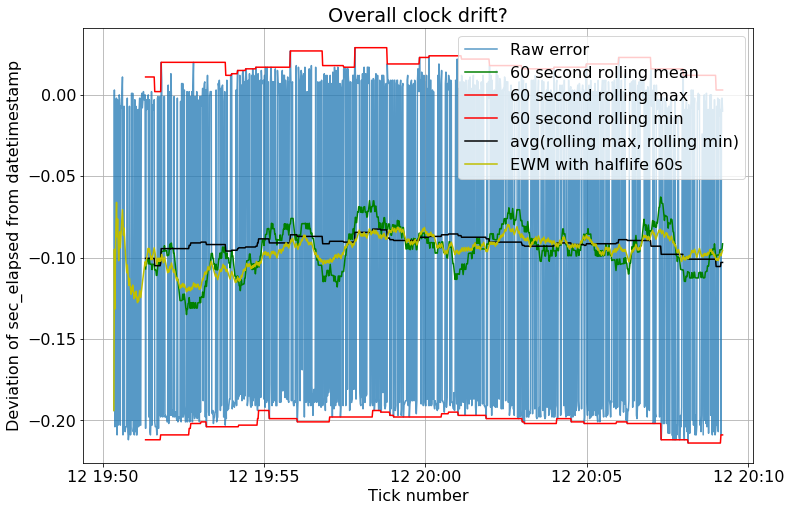

In [21]:
# check clock drift by checking our linear fit

perfect_line = 

## Entries per second

In [47]:
elapsed_secs = []
entries_per_tick = []
max_elapsed_secs = 0;
max_elapsed_idx = 0;
max_elapsed_ticknum = 0;

# cut the first 10 rows, which contain major outliers
for i in range(10, len(indices)-1):
    t = df["sec_elapsed"].values[indices[i+1]] - df["sec_elapsed"].values[indices[i]]
    entries = indices[i+1] - indices[i]
    if (t > max_elapsed_secs and i > 100):
        max_elapsed_secs = t
        max_elapsed_idx = indices[i]
        max_elapsed_ticknum = i
    elapsed_secs.append(t)
    entries_per_tick.append(entries)


# look for all 2-entry sequences
two_tick_sequences = [[0,0,0],
                      [0,0,0],
                      [0,0,0]]
# [first][second], 0= <5 entries, 1=5 entries, 2= >5 entries, 3=outliers
 
first_val=100
first_idx=1
for i in range(len(entries_per_tick)):
    e = entries_per_tick[i]
    if (e < 70): continue
    elif (e >= 70 and e < 90): second_idx = 0
    elif (e >= 90 and e < 105): second_idx = 1
    elif (e >= 105 and e < 120): second_idx = 2
    else: continue
    
    two_tick_sequences[first_idx][second_idx] += 1
    
    first_val = entries_per_tick[i]
    first_idx = second_idx
    
print(two_tick_sequences)
    

[[3, 145, 143], [146, 257, 145], [142, 146, 0]]


small: 291 entries, avg = 77.47422680412372
medium: 548 entries, avg = 96.76642335766424
large: 288 entries, avg = 116.05555555555556
outliers: 3
overall mean #entries: 96.60176991150442
1130
1130


KeyError: 'no_rtk_lon'

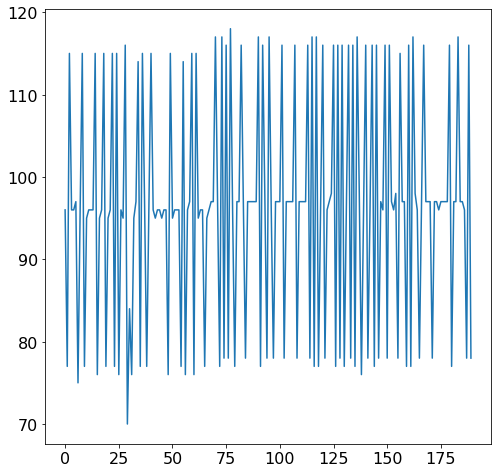

In [43]:
# Is there a pattern to how many entries there are for each second?

plt.figure()
plt.plot(entries_per_tick[10:200])

# It looks like there are 3 values, with very little in between:
# 75-80, 95-100, and ~115
# I want to try to answer the following:
# 1. Can we predict which of the 3 ranges a second will have, given some range of previous seconds?
# 2. Does the actual value in each range drift over time, or is it steady?

# NOTE! WARNING! HERE BE DRAGONS!!
# This is *NOT* analysis on any actual properties of the drone!
# It is analysis of what DatCon is doing to our data.
# Expect to see lots of patterns where there are none, beat frequencies, and other fun sampling artifacts
# These issues should be addresed with better use/replacement of DatCon, NOT by our analysis Python

# anyway.
# the 3 bins.

small = [] # [70-90)
medium = [] # [90-105)
large = [] # [105-120)
outliers = [] # <70 or >120

for i in range(len(entries_per_tick)):
    e = entries_per_tick[i]
    if (e < 70):
        outliers.append(e)
    elif (e >= 70 and e < 90):
        small.append(e)
    elif (e >= 90 and e < 105):
        medium.append(e)
    elif (e >= 105 and e < 120):
        large.append(e)
    else:
        outliers.append(e)
        
print("small: "+str(len(small))+" entries, avg = "+str(np.mean(small)))
print("medium: "+str(len(medium))+" entries, avg = "+str(np.mean(medium)))
print("large: "+str(len(large))+" entries, avg = "+str(np.mean(large)))
print("outliers: "+str(len(outliers)))
print("overall mean #entries: "+str(np.mean(entries_per_tick)))

# DatCon is set to target 100Hz data output, regardless of what data it actually recieves
# So, 97 samples in a second is close to the expected output
# And over time, even with outliers/deviations, the average output is 97 samples per second.

# The really weird part is the discrete increments - why not 105 and 90??
# For some reason, if a second is short on entries, it will be short by ~19 entries,
# and if it has excessive entries, it will be over by ~19 entries
# I think this suggests that there is something in DatCon that occurs at 100/20 = 5hz, and we get 4, 5, or 6
# of those events in any given second

# https://datfile.net/DatCon/fieldsV3.html
# GPS updates are 5Hz internally

# Why would this cause ~200ms timing errors??
# What if there are sometime 4, 5, or 6 GPS packets sharing a single timestamp
# This could happen if the clock on the drone is out of sync with GPS time?


# indices is a list of indices where the seconds tick
unique_locs = []
cut_indices = indices[trim:-1]
print(len(indices[trim:-1]))
print(len(entries_per_tick))
for i in range(len(cut_indices)):
    unique_locs.append(0)
    last_lon = 0
    last_lat = 0
    for j in range(entries_per_tick[i]):
        if (df["no_rtk_lon"].values[cut_indices[i]+j] != last_lon
           or df["no_rtk_lat"].values[cut_indices[i]+j] != last_lat):
            unique_locs[i] += 1
            last_lon = df["no_rtk_lon"].values[cut_indices[i]+j]
            last_lat = df["no_rtk_lat"].values[cut_indices[i]+j]

fig = plt.figure()
n, bins, patches = plt.hist(unique_locs, density=1, facecolor='green')
plt.ylabel("Counts")
plt.xlabel("Number of entries")
plt.grid()
plt.title("Number of GPS solutions sharing a datetimestamp")
plt.show()

# Timestamp/Clock Offset Testing

## How I had been generating timestamps
[My old way of making timestamps](#Previous-timestamp-generator) synced `sec_elapsed` with `datetimestamp` once at the beginning of the file, then used `sec_elapsed` to determine how many milliseconds to add to `datetimestamp`. 

This avoids any assumptions about equally spaced data rows.

On the other hand, it assumes that there is zero clock drift in `sec_elapsed`, and that the seconds reported by `datetimestamp` is a correct measure of `floor(seconds)` of 'true' UTC. It turns out that neither of these assumptions are true.

## The $\pm$1s offsets are 'my fault'
Comparing `sec_elapsed` and `datetimestamp` for `FLY342.csv`, a BNL map known to have ~1s of offset, we do find the ~1s offset in between the two timestamps, indicating that this offset was produced in my interpolation code. [Plot here](#Old-vs.-New-comparison)

## A quick attempt at some better interpolation
[I've written up a different timestamp interpolator](#New-timestamp-generator), which does the following interpolation:
 * Assume that the first row you see with a new `datetimestamp` is at seconds=0.000
 * Count how many rows share that timestamp
 * Interpolate milliseconds assuming equal spacing between rows
 
This fixes the systematic offset, but I believe it is not a complete or correct solution (and not just because of equal spacing issues)

## Why did this happen? (DateTimeStamp may not be a reliable clock reference)

### Investigations
#### "Seconds per Second"
I began by investigating how much time elapsed on the `sec_elapsed` counter between each tick of the `datetimestamp` clock. [Plots here](#Investigating-the-errors). The answer was: between 0.8 and 1.2, usually, in an oddly discrete distribution. In addition, there was a very strong correlation between the number of entries in a `datetimestamp` second, and the number of `sec_elapsed` seconds.

#### Looks like there's something 5Hz about this...
I then [decided to look at](#entries-per-second) how many samples are recorded in each `datetimestamp` second. DatCon is set by default to produce a data rate of 100Hz, and there were an average of 97 samples per `datetimestamp` second (roughly as expected). However, the distribution of the number of samples was very discrete, with either 19 fewer or 19 more samples, when the count deviated from 97. So, there is something going on at 97/19 $\approx$ 5Hz.

### How DateTimeStamp is generated
According to [DatCon's column descriptions](https://datfile.net/DatCon/fieldsV3.html), all of the GPS fields are running at a rate of 5Hz. These fields include: Non-RTK Lat/Lon/HMSL, Date, and Time. DatCon generates the `GPS_dateTimeStamp` field using the GPS Date and Time fields, combined and converted to UTC. My code reads this column in, renames it to `datetimestamp`, and does nothing else.

So: **The `datetimestamp` field is updated at a rate of 5Hz**

### Why does this cause timing errors?

#### ~200ms errors
The `datetimestamp` column is theoretically a 5Hz datastream, and should contain 5 entries for each clock tick. But, it frequently contains 4 or 6, and infrequently contains 3 or fewer entries. So, when we assume that the `datetimestamp` is correct and progressing at 1 second per second, we produce a significant number of 0.8 second long seconds and 1.2 second long seconds. 
#### ~500-1000ms errors
The `sec_elapsed` column is especially out of sync with `datetimestamp` at the beginning of the file. Based on vague instincts from my experience working with GPS, I would guess that this is because the GPS is "warming up" (i.e. finding satellites and integrating its location) at the beginning of the flight, and it is the `datetimestamp` field that is wrong.

## Conclusions(?)
 * At this point, I don't trust either the `sec_elapsed` field or the `datetimestamp` field, which makes it difficult to do meaningful error analysis or test interpolation methods. 
 * DatCon is taking a stream of data packets of varying frequency and turning it into a 100Hz datastream, where each entry shares a timestamp. This is not a trivial conversion, especially when we care about timing precision.
 * I need to spend some time looking at what exactly DatCon is doing, and if there are settings that will produce fewer timing artifacts